In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re 
import scipy
from scipy import sparse
from IPython.display import display
from pprint import pprint
from matplotlib import pyplot as plt 
import time
import scipy.optimize as optimize
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.linear_model import Ridge
import zipfile
import string
import nltk
import string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer() 

In [4]:
!pip install seaborn==0.11.0

data collecting

In [5]:
train_csv_zip_path = '../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip'
with zipfile.ZipFile(train_csv_zip_path) as zf:
    zf.extractall('./')


In [6]:
train_csv_path = './train.csv'
sample_sub_path = '../input/jigsaw-toxic-severity-rating/sample_submission.csv'
comments_to_score_path = '../input/jigsaw-toxic-severity-rating/comments_to_score.csv'
val_path='../input/jigsaw-toxic-severity-rating/validation_data.csv'

In [7]:
df_train = pd.read_csv("./train.csv")
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

In [8]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
df_sub.head()

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [10]:
for col in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
#     print(f'------------------------{col}-----------------------')
    print(col.center(40, '.'))
    display(df_train.loc[df_train[col]==1,['comment_text',col]].sample(2))

.................toxic..................


,comment_text,toxic
69742,fletch is mad at hu\nhay shit for brains why d...,1
129353,"""A RESPONSE TO . I ENTITLE THIS """"YOUR STUPIDI...",1


..............severe_toxic..............


,comment_text,severe_toxic
24650,Fuck off. You have unwarranted self importance.,1
84288,you are dumb \n\nMexican Punk is the god of al...,1


................obscene.................


,comment_text,obscene
73390,so you can pick on Palestinian babies with you...,1
113301,"You're not Hitler, just just another idiot!",1


.................threat.................


,comment_text,threat
17580,"You Hurt My Feelings For The Last Time, Gladys...",1
59567,"""\n\nGreat\nGo and die painfully you foul mout...",1


.................insult.................


,comment_text,insult
28972,"You know what, fuck you, go revert my edit. Th...",1
157527,Oh you scared me !!! I am so much terrified by...,1


.............identity_hate..............


,comment_text,identity_hate
80358,I FUCKING HATE NIGGERS AND SPICS AND JEWS AND ...,1
49979,Plus you are all gay for questioning this bull...,1


data preprocessing

follow the instructions: https://medium.com/analytics-vidhya/text-cleaning-in-natural-language-processing-nlp-bea2c27035a6

Data Preprocessing must include the follows:

Removing HTML characters,ASCII

Convert Text to Lowercase

Remove Punctuation's

Remove Stop words

Tokenization

Stemming vs Lemmatization


In [11]:
def clean_text(text):
#replace the html characters with " "
    text=re.sub('<.*?>', ' ', text)  
#remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
#consider only alphabets and numerics
    text = re.sub('[^a-zA-Z]',' ',text)  
#replace newline with space
    text = re.sub("\n"," ",text)
#convert to lower case
    text = text.lower()
#split and join the words
    text=' '.join(text.split())
    return text

def stopwords(input_text, stop_words):
    word_tokens = word_tokenize(input_text) 
    output_text = [w for w in word_tokens if not w in stop_words]
    output = [] 
    for w in word_tokens: 
        if w not in stop_words:
            output.append(w)
            
    text = ' '.join(output)
    return text



In [12]:
unrelevant_words = ['wiki','wikipedia','page']
#Clean step 1, 2 and 3
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ''.join([w for w in clean_text(x) if w not in unrelevant_words]))

#Clean Step 4
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ''.join([w for w in stopwords(x,stop_words)]))

#Clean Step 5
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ''.join([w for w in lemmatizer.lemmatize(x)]))

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour im seemingly st...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


reference:

https://medium.com/analytics-vidhya/text-cleaning-in-natural-language-processing-nlp-bea2c27035a6

In [13]:
for col in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    print(col.center(40, '.'))
    display(df_train.loc[df_train[col]==1,['comment_text',col]].sample(2))

.................toxic..................


,comment_text,toxic
72438,guess revert bitch,1
40967,jews iasi iasi history many things happened bu...,1


..............severe_toxic..............


,comment_text,severe_toxic
141898,thats fucking pig spread propaganda much made ...,1
122469,arsehole fucking bastard son bitch asshole mot...,1


................obscene.................


,comment_text,obscene
125806,gay think really really gay probably suck dick...,1
27387,waste time suppose people asigned protect wiki...,1


.................threat.................


,comment_text,threat
4733,still find anything important like killing,1
111128,matey youuu think big boi whoever wrote shit b...,1


.................insult.................


,comment_text,insult
157049,page aaa mean old bullshitting fartas would put,1
26872,haha would references lazy read troll,1


.............identity_hate..............


,comment_text,identity_hate
112990,twat twat twat twat twat twat twat twat twatcu...,1
152749,suck suck canadian bacon scummy hockey playing...,1


In [14]:
df_train['y'] = (df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
df_train_binary = df_train[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df_train_binary.sample(5)

,text,y
98265,added notice extremely reform jew prod templat...,0
52892,yes aside thank trying answer blockrelated con...,0
71742,two moments still talked years demise wcw make...,0
109011,afd ended august single didnt hit charts octob...,0
12205,swastika braiding tool spinning tool httprexcu...,0


In [15]:
 display(df_train_binary.loc[df_train_binary['y']==1,['text','y']].sample(5))

,text,y
5303,screw motherfucker personal attack im implying...,1
78449,oi heard dissing friend hell like life,1
28156,wikipedia free online encyclopedia unfortunate...,1
176,think fagget get oife burn hell hate sorry can...,1
148975,refer blacks africanamerican sounds like natio...,1


In [16]:
 display(df_train_binary.loc[df_train_binary['y']==0,['text','y']].sample(5))

,text,y
149546,pending changes article one number selected ea...,0
16745,nahome obviously work hbi tobacco looking hist...,0
44693,cool beans thanks far scenes cut doesnt seem t...,0
152517,spank much send,0
38870,amjikian thing myotis trying say believe artic...,0


In [17]:
df_lt=df_train_binary.loc[df_train_binary['y']==0]
df_lt.head()
# print(len(df_lt))

,text,y
0,explanation edits made username hardcore metal...,0
1,daww matches background colour im seemingly st...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestions improvement wondere...,0
4,sir hero chance remember page thats,0


There are 36927606 words in the combination of all less_toxic reviews.


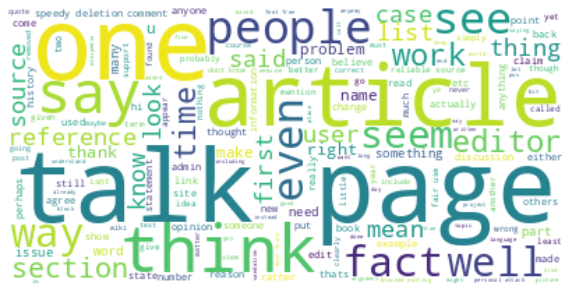

In [18]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# text_lt = " ".join(t for t in df["less_toxic"])

text_lt = " ".join(t for t in df_lt['text'])
print ("There are {} words in the combination of all less_toxic reviews.".format(len(text_lt)))

#Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS,background_color="white").generate(text_lt)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
df_mt=df_train_binary.loc[df_train_binary['y']==1]
df_mt.head()

,text,y
6,cocksucker piss around work,1
12,hey talk exclusive group wp talibanswho good d...,1
16,bye dont look come think comming back tosser,1
42,gay antisemmitian archangel white tiger meow g...,1
43,fuck filthy mother ass dry,1


There are 3176069 words in the combination of all more_toxic reviews.


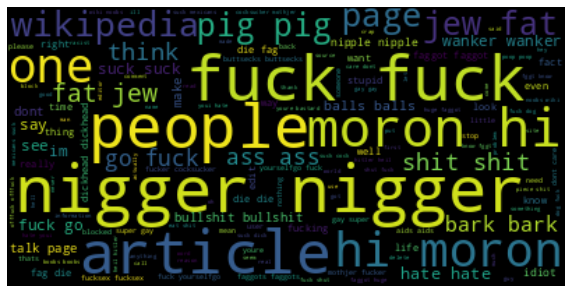

In [20]:
text_mt = " ".join(t for t in df_mt['text'])
print ("There are {} words in the combination of all more_toxic reviews.".format(len(text_mt)))

#Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS,background_color="black").generate(text_mt)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Unbalanced dataset**

In [21]:
df_train_binary['y'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: y, dtype: float64

In [22]:
toxic_len = (df_train_binary['y'] == 1).sum()
print(toxic_len)

16225


In [23]:
df_train_balanced = df_train_binary[df_train_binary['y'] == 0].sample(n=toxic_len)
df_train_balanced['y'].value_counts(normalize=True)

0    1.0
Name: y, dtype: float64

**Balanced dataset**

In [24]:
df_train_b = pd.concat([df_train_binary[df_train_binary['y'] == 1], df_train_balanced])
df_train_b['y'].value_counts()

1    16225
0    16225
Name: y, dtype: int64

**TF-IDF**

In [25]:
# vec = TfidfVectorizer()

In [26]:
# X = vec.fit_transform(df_train_b['text'])
# X

In [27]:
# from sklearn.naive_bayes import MultinomialNB
# model = MultinomialNB()
# model.fit(X, df_train_b['y'])

In [28]:
# df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
# df_val.head()

In [29]:
# unrelevant_words = ['wiki','wikipedia','page']
# #Clean step 1, 2 and 3
# df_val['less_toxic'] = df_val['less_toxic'].apply(lambda x: ''.join([w for w in clean_text(x) if w not in unrelevant_words]))

# #Clean Step 4
# df_val['less_toxic'] = df_val['less_toxic'].apply(lambda x: ''.join([w for w in stopwords(x,stop_words)]))

# #Clean Step 5
# df_val['less_toxic'] = df_val['less_toxic'].apply(lambda x: ''.join([w for w in lemmatizer.lemmatize(x)]))

# df_val.head()

In [30]:
# df_val['more_toxic'] = df_val['more_toxic'].apply(lambda x: ''.join([w for w in clean_text(x) if w not in unrelevant_words]))

# #Clean Step 4
# df_val['more_toxic'] = df_val['more_toxic'].apply(lambda x: ''.join([w for w in stopwords(x,stop_words)]))

# #Clean Step 5
# df_val['more_toxic'] = df_val['more_toxic'].apply(lambda x: ''.join([w for w in lemmatizer.lemmatize(x)]))

# df_val.head()

In [31]:
# X_less_toxic = vec.transform(df_val['less_toxic'])
# X_more_toxic = vec.transform(df_val['more_toxic'])

In [32]:
# p1 = model.predict_proba(X_less_toxic)
# p2 = model.predict_proba(X_more_toxic)

In [33]:
# (p1[:, 1] < p2[:, 1]).mean()

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df_train_b['text']).toarray()
labels = df_train_b['y']
features.shape

(32450, 22230)

In [35]:
# features_less_toxic = (df_val['less_toxic'])
# tfidf.transform(features_less_toxic).toarray()
# X_val_less_toxic =tfidf.fit_transform(features_less_toxic).toarray()
# # features_more_toxic = tfidf.fit_transform(df_val['more_toxic']).toarray()
# X_val_less_toxic.shape

In [36]:
# from io import StringIO
# col = ['y', 'text']
# df = df_train_binary[col]
# df = df[pd.notnull(df['text'])]
# df.columns = ['y', 'text']
# df['category_id'] = df['y'] .factorize()[0]
# category_id_df = df[['y', 'category_id']].drop_duplicates().sort_values('category_id')
# category_to_id = dict(category_id_df.values)
# id_to_category = dict(category_id_df[['category_id', 'y']].values)
# df.head()


In [37]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 2
# for y,category_id in sorted(category_to_id.items()):
#   features_chi2 = chi2(features, labels == category_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("# '{}':".format(y))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

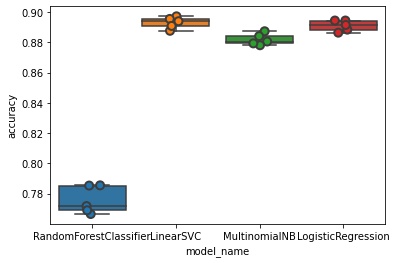

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [44]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.893066
LogisticRegression        0.891063
MultinomialNB             0.881911
RandomForestClassifier    0.775655
Name: accuracy, dtype: float64

In [ ]:

# features_less_toxic = tfidf.transform(df_val['less_toxic'])
# features_less_toxic =features_less_toxic.fit_transform(president)


In [46]:

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

svm = LinearSVC()
clf = CalibratedClassifierCV(svm) 
clf.fit(features, labels)




CalibratedClassifierCV(base_estimator=LinearSVC())

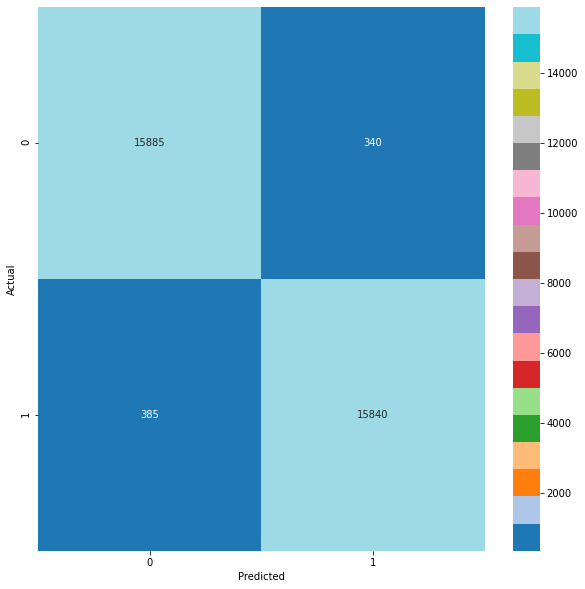

In [45]:
import seaborn as sns
y_pred = clf.predict(features)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(labels, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
cmap = "tab20"
sns.heatmap(conf_mat, annot=True, fmt='d',cmap=cmap)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [47]:
df_test = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')
df_test.head()

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7537 entries, 0 to 7536
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  7537 non-null   int64 
 1   text        7537 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.9+ KB


In [49]:
X_test = df_test['text']
X_test.head()

0    "\n \n\nGjalexei, you asked about whether ther...
1    Looks like be have an abuser , can you please ...
2    I confess to having complete (and apparently b...
3    "\n\nFreud's ideas are certainly much discusse...
4    It is not just you. This is a laundry list of ...
Name: text, dtype: object

In [50]:
# X_test= tfidf.fit_transform(df_test['text']).toarray()
X_test= tfidf.transform(df_test['text'])
X_test.shape

(7537, 22230)

In [51]:
# svm = LinearSVC()
# clf = CalibratedClassifierCV(svm) 
# clf.fit(features, labels)
y_test = clf.predict_proba(X_test)
len(y_test)

7537

In [52]:
df_test['score'] = y_test[:, 1]
df_test['score'].head()

0    0.023667
1    0.093164
2    0.176581
3    0.206861
4    0.984223
Name: score, dtype: float64

In [53]:
df_test.head()

,comment_id,text,score
0,114890,"""\n \n\nGjalexei, you asked about whether ther...",0.023667
1,732895,"Looks like be have an abuser , can you please ...",0.093164
2,1139051,I confess to having complete (and apparently b...,0.176581
3,1434512,"""\n\nFreud's ideas are certainly much discusse...",0.206861
4,2084821,It is not just you. This is a laundry list of ...,0.984223


In [55]:
df_test[['comment_id', 'score']].to_csv("submission.csv", index=False)

In [ ]:
# model = LogisticRegression(random_state=0)
# # X_train, y_train = train_test_split(features, labels)
# model.fit(features, labels)
# y_pred = model.predict(X_test)
# len(y_pred)